In [1]:
%matplotlib inline

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

In [3]:
def f(x):
    return -5*(x**2) + (1/6)*x**3  + 0.5*x**4 + 20

In [4]:
x = np.linspace(-3, 3, 100)
y = np.vectorize(f)(x)

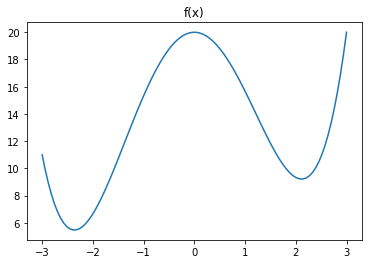

In [5]:
plt.plot(x, y)
plt.title("f(x)")
plt.savefig("./figures/01_fx.png")

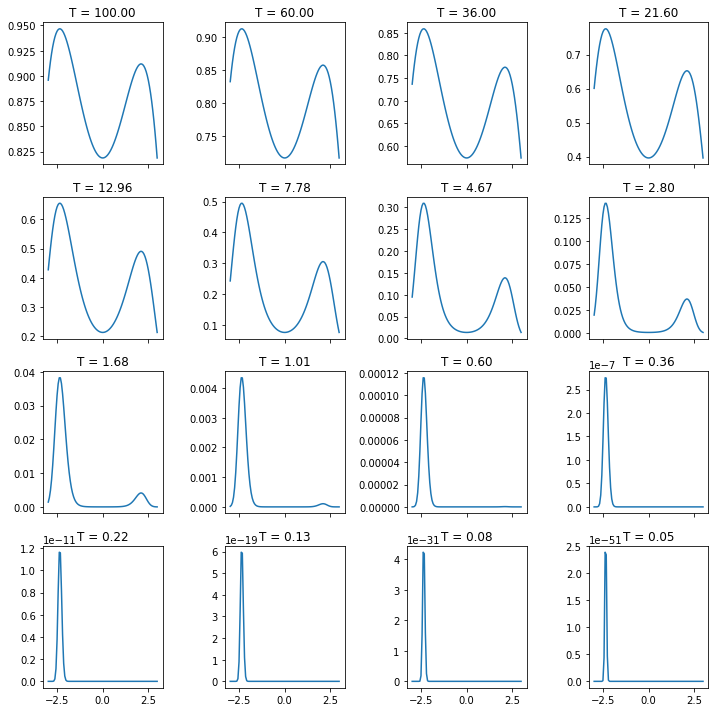

In [38]:
ts = np.zeros(16)
a = np.zeros((16, len(y)))
ts[0] = 100

_, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True)

for ax, i in zip(axes.flatten(), range(0, len(ts))):
    if i > 0:
        ts[i] = ts[i-1] * 0.6
        
    a[i] = np.exp(-y/ts[i])
    
    ax.plot(x, a[i])
    ax.set_title("T = %0.2f" % ts[i])
    
plt.tight_layout()
plt.savefig("./figures/01_efx.png")

In [41]:
e = np.zeros((16,100))
t = 100
ts = []
for r in range(16):
    if r > 0:
        t = t * 0.6
    x1 = np.random.uniform(-3,3, 100)
    x2 = np.random.uniform(-3,3, 100)
    
    fx1 = f(x1)
    fx2 = f(x2)
    
    e[r] = np.exp((fx1 - fx2)/t)
    e[r, e[r] >= 1] = np.nan # Let's only look at the cases where fx1 < fx2
    
    ts.append(t)

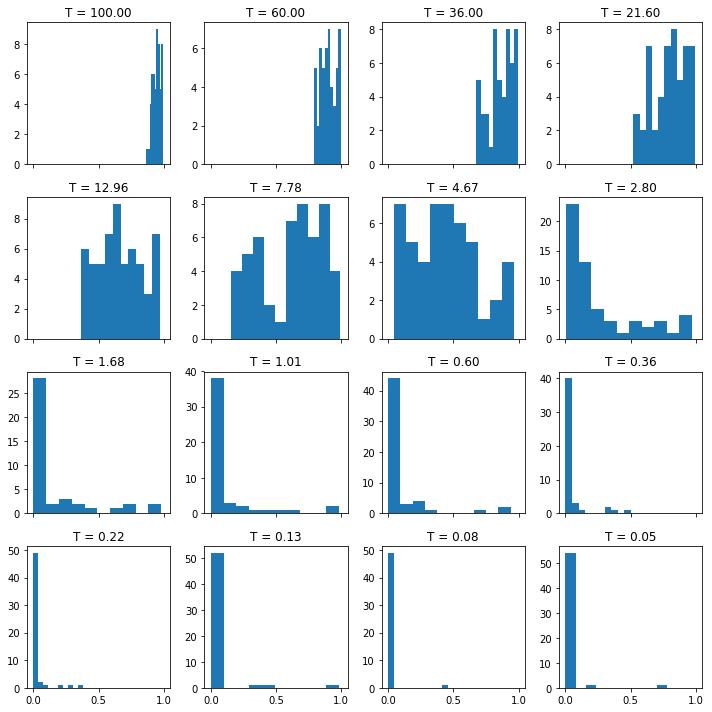

In [42]:
fig, axes = plt.subplots(4, 4, figsize=(10,10), sharex=True)
for i, ax in enumerate(axes.flatten()):
    v = e[i, ~np.isnan(e[i])]
    ax.hist(v, bins=10)
    ax.set_title("T = %0.2f" % ts[i])
    
plt.tight_layout()
plt.savefig("./figures/01_alpha.png")

# Nurse scheduling problem

In [397]:
num_nurses = 10
num_weeks = 10
preferred_len = np.random.randint(1, 6, 10)
cost = np.random.randint(1, 7, 10)

In [398]:
total_len = preferred_len.sum()
preferred_len_prob = [x/total_len for x in preferred_len]

In [399]:
days_of_week = ['m','tu','w','th','f','sa','su']
Weektuple = namedtuple('week', days_of_week)
class Week(Weektuple):
    
    def days_works(self, n):
        return sum([x==n for x in self])
    

In [424]:
schedule = [Week(**dict(zip(days_of_week, np.random.randint(0,10,10)))) for w in range(num_weeks)]

In [386]:
def loss_func(schedule):
    l1 = sum([len_loss(w) for w in schedule])
    #l2 = staffing_cost(schedule)
    l3 = shift_loss(schedule)
    
    return l1 + l3

In [388]:
def len_loss(w):
    loss = 0
    
    for n in range(num_nurses):
        n_work_days = w.days_works(n)
        if w.days_works(n) > 0:
            loss += np.abs(n_work_days - preferred_len[n])
    
    return loss

In [341]:
def staffing_cost(schedule):
    return sum([staffing_cost_week(w) for w in schedule])

def staffing_cost_week(week):
    return sum([cost[n] * week.days_works(n) for n in range(num_nurses)])

In [353]:
def shift_loss(schedule):
    
    total_shifts = np.zeros(num_nurses)
    
    for w in schedule:
        for n in range(num_nurses):
            total_shifts[n] = w.days_works(n)
    
    total_shifts = total_shifts / total_shifts.sum()
    
    return 2 * num_nurses * num_weeks * np.abs(preferred_len_prob - total_shifts).sum()

In [401]:
def proposal(schedule, perc_flip = 0.5, per_flip = 2):
    weeks_to_flip = [ x for x in range(len(schedule)) if (np.random.random() > perc_flip) ]
    #print(weeks_to_flip)
    
    new_schedule = schedule.copy()
    
    for w in weeks_to_flip:
        new_schedule[w] = increment(new_schedule[w], per_flip)
    
    return new_schedule

def increment(w, num = 2):
    
    new_w = w._asdict()
    
    for i in range(num):
        day = days_of_week[np.random.randint(0, 7)]

        if new_w[day] == (num_nurses - 1): new_w[day] = 0
        else: new_w[day] += 1
    
    return Week(**new_w)

In [389]:
def sim_anneal(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    """
    Run simulated annealing.
    """
    
    # Accumulate results in the same form as initals
    accumulator=[]
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    for index in range(epochs):
        #print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        
        if not index % 5:
            print("EPOCH", index, ": Temperature", T, "Length", length, 'Loss': best_energy)
        #print(old_solution)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted+=1.0
                accumulator.append({'epoch':index, 'T':T, 'schedule':new_solution, 
                                    'loss':new_energy, 'iteration':total})
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                    
                old_energy = new_energy
                old_solution = new_solution
            else:
                accumulator.append({'epoch':index, 'T':T, 'schedule':old_solution, 
                                    'loss':old_energy, 'iteration':total})
    
    print("------")
    print("\nFrac accepted : ", accepted/total, "\nTotal iterations : ", total, "\nSolution :", old_solution)
    print("Final Energy :", best_energy, "Final length :", length)
    return best_energy, best_solution, accumulator

In [482]:
days_of_week

['m', 'tu', 'w', 'th', 'f', 'sa', 'su']

In [491]:
def plot_schedule(schedule):
    all_data = {}
    for i, w in enumerate(bs):
        all_data['week' + str(i)] = w._asdict()
    
    df = pd.DataFrame(all_data)
    df = df.loc[days_of_week,:].T
    ax = sns.heatmap(df, cmap="Set1", linewidths=1)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(0.5, num_nurses - 1 + 0.5, num_nurses ))
    cbar.set_ticklabels(np.linspace(0.5, num_nurses - 1 + 0.5, num_nurses ) - 0.5)

    return df

In [477]:
np.linspace(0.5, num_nurses - 1 + 0.5, num_nurses )

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [474]:
num_nurses

10

In [417]:
from functools import partial
prop_part = partial(proposal, perc_flip = 0.5, per_flip = 3)

In [459]:
initials = {}
initials['T'] = 5000
initials['solution'] = schedule
initials['length'] = 7

epochs = 90

tempfunc = lambda t: t * 0.9
lengthfunc = lambda l : int(np.ceil(l * 1.1))


be, bs, acc = sim_anneal(loss_func, initials, epochs, tempfunc, lengthfunc, prop_part)

EPOCH 0 : Temperature 5000 Length 7
EPOCH 5 : Temperature 2952.4500000000003 Length 13
EPOCH 10 : Temperature 1743.3922005000004 Length 24
EPOCH 15 : Temperature 1029.4556604732452 Length 41
EPOCH 20 : Temperature 607.8832729528467 Length 70
EPOCH 25 : Temperature 358.94899384592657 Length 115
EPOCH 30 : Temperature 211.9557913760812 Length 188
EPOCH 35 : Temperature 125.15777524966221 Length 305
EPOCH 40 : Temperature 73.90441470717305 Length 494
EPOCH 45 : Temperature 43.63981784043861 Length 798
EPOCH 50 : Temperature 25.768876036600595 Length 1287
EPOCH 55 : Temperature 15.216263610852286 Length 2075
EPOCH 60 : Temperature 8.985051499572167 Length 3346
EPOCH 65 : Temperature 5.30558305998237 Length 5392
EPOCH 70 : Temperature 3.13289374108899 Length 8687
EPOCH 75 : Temperature 1.8499424251756378 Length 13994
EPOCH 80 : Temperature 1.0923725026419624 Length 22541
EPOCH 85 : Temperature 0.6450350390850524 Length 36306
------

Frac accepted :  0.06127395185239069 
Total iterations :  

In [460]:
acc_df = pd.DataFrame(acc)

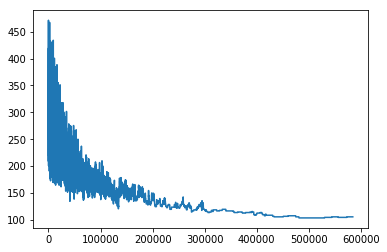

In [461]:
plt.plot(acc_df.loss)

In [462]:
bs, be

([Week(m=6, tu=6, w=6, th=7, f=7, sa=7, su=6),
  Week(m=5, tu=3, w=3, th=5, f=5, sa=5, su=1),
  Week(m=7, tu=7, w=7, th=1, f=3, sa=3, su=7),
  Week(m=1, tu=9, w=0, th=9, f=3, sa=3, su=9),
  Week(m=7, tu=1, w=7, th=7, f=3, sa=1, su=3),
  Week(m=1, tu=3, w=3, th=0, f=3, sa=3, su=0),
  Week(m=5, tu=3, w=5, th=5, f=5, sa=1, su=3),
  Week(m=3, tu=4, w=3, th=4, f=4, sa=4, su=4),
  Week(m=5, tu=3, w=7, th=7, f=7, sa=5, su=7),
  Week(m=4, tu=5, w=9, th=8, f=3, sa=2, su=6)],
 103.66666666666666)

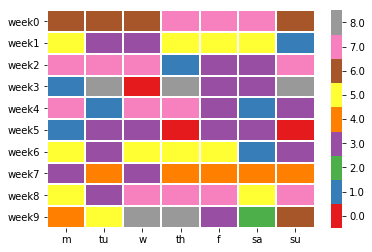

In [489]:
_ = plot_schedule(bs)

In [487]:
_

,week0,week1,week2,week3,week4,week5,week6,week7,week8,week9
m,6,5,7,1,7,1,5,3,5,4
tu,6,3,7,9,1,3,3,4,3,5
w,6,3,7,0,7,3,5,3,7,9
th,7,5,1,9,7,0,5,4,7,8
f,7,5,3,3,3,3,5,4,7,3
sa,7,5,3,3,1,3,1,4,5,2
su,6,1,7,9,3,0,3,4,7,6


In [436]:
dict(zip(range(1,10), preferred_len))

{1: 2, 2: 1, 3: 4, 4: 2, 5: 5, 6: 5, 7: 5, 8: 3, 9: 5}

In [423]:
dict(zip(range(10), cost))

{0: 1, 1: 3, 2: 4, 3: 2, 4: 5, 5: 5, 6: 2, 7: 1, 8: 4, 9: 3}